<a href="https://colab.research.google.com/github/GreatLearningAIML1/gurgaon-feb-batch-abhishek02git/blob/master/GL_Project_2_SVHN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#download data file not found on local machine
import glob
if len(glob.glob('SVHN_single_grey1.h5'))==0:
  ! wget 'http://h0.ai/static/SVHN_single_grey1.h5'
! ls -al

--2019-08-26 09:17:05--  http://h0.ai/static/SVHN_single_grey1.h5
Resolving h0.ai (h0.ai)... 207.180.211.174
Connecting to h0.ai (h0.ai)|207.180.211.174|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491644096 (469M) [application/octet-stream]
Saving to: ‘SVHN_single_grey1.h5’

SVHN_single_grey1.h 100%[===================>] 468.87M  9.17MB/s    in 78s     

2019-08-26 09:18:23 (6.00 MB/s) - ‘SVHN_single_grey1.h5’ saved [491644096/491644096]

total 480144
drwxr-xr-x 1 root root      4096 Aug 26 09:17 .
drwxr-xr-x 1 root root      4096 Aug 26 08:56 ..
drwxr-xr-x 1 root root      4096 Aug 22 16:14 .config
drwxr-xr-x 1 root root      4096 Aug 22 16:14 sample_data
-rw-r--r-- 1 root root 491644096 Aug 17 17:30 SVHN_single_grey1.h5


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import h5py

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
#from tensorflow.compact.v1.keras.backend import K


from tensorflow.keras.layers import Dense, Activation, Input, Flatten, Reshape, MaxPool2D, BatchNormalization 

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [0]:
#Load and Prepare Data
dset = h5py.File('SVHN_single_grey1.h5','r')
X_train = np.array(dset['X_train'])
X_test = np.array(dset['X_test'])
X_val = np.array(dset['X_val'])
y_train = np.array(dset['y_train'])
y_test  = np.array(dset['y_test'])
y_val = np.array(dset['y_val'])

print ("Training ", X_train.shape)
print ("Testing ", X_test.shape)
print ("Validation ", X_val.shape)

Training  (42000, 32, 32)
Testing  (18000, 32, 32)
Validation  (60000, 32, 32)


In [0]:
# Prepare data for NN training
X_train_nn = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test_nn = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_val_nn = X_val.reshape(X_val.shape[0],X_train.shape[1],X_val.shape[2],1)
y_train_nn = keras.utils.to_categorical(y_train)
y_test_nn  = keras.utils.to_categorical(y_test)
y_val_nn = keras.utils.to_categorical(y_val)

In [0]:
# Implement KNN
from sklearn.metrics import classification_report 
X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print ("Running KNN on K = 25")
knn = KNeighborsClassifier(n_neighbors = 25,n_jobs=-1)
knn.fit(X_train_flat,y_train)
y_pred = knn.predict(X_test_flat)
score = metrics.accuracy_score(y_test,y_pred)
print ("Accuracy Score", score)
print ("Classification Report at K =25")
print (classification_report(y_test,y_pred))

# Did not run KNN for multiple values as this was very slow. Its took 30+ mins for one K value

Running KNN on K = 25
Accuracy Score 0.5296666666666666
Classification Report at K =25
              precision    recall  f1-score   support

           0       0.45      0.71      0.55      1814
           1       0.46      0.73      0.56      1828
           2       0.63      0.54      0.58      1803
           3       0.46      0.42      0.44      1719
           4       0.64      0.65      0.65      1812
           5       0.52      0.39      0.45      1768
           6       0.50      0.41      0.45      1832
           7       0.71      0.63      0.67      1808
           8       0.47      0.37      0.41      1812
           9       0.55      0.44      0.49      1804

    accuracy                           0.53     18000
   macro avg       0.54      0.53      0.52     18000
weighted avg       0.54      0.53      0.53     18000



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


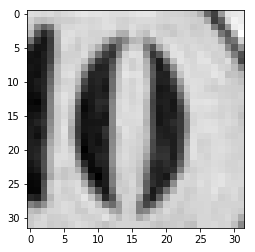

In [0]:
print (y_train_nn[11])
plt.imshow(X_train_nn[11].reshape(32,32),cmap='gray')

In [0]:
# Network parameters
latent_dim = 1000
input_shape = (32,32,1)
kernal_size = 3
strides = 1
layer_filters = [32,64,128,256]
dnn_units = [latent_dim,1000,500,100]
output_unit = 10

In [0]:
inputs = keras.layers.Input(shape=input_shape,name='Input')
conv = inputs
for filters in layer_filters:
  conv = keras.layers.Conv2D(filters=filters,kernel_size=kernal_size,kernel_initializer='he_uniform', strides=strides,padding='same')(conv)
  conv = keras.layers.LeakyReLU(alpha=0.3)(conv)
  conv = keras.layers.AveragePooling2D(pool_size=(2,2))(conv)
  conv = keras.layers.BatchNormalization()(conv)

# Shape info needed to build Decoder Model
shape = K.int_shape(conv)

flat = keras.layers.Flatten()(conv)
latent = keras.layers.Dense(units=latent_dim, name='Latent_vector')(flat)
encoder = keras.models.Model(inputs,latent,name='encoder')
print ("Encoder Model")
print(encoder.summary())

W0826 10:48:56.031989 139861901346688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Encoder Model
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 6

In [0]:
#Create fully connected layer

dnn_input = keras.layers.Input(shape=latent_dim,name='dnn_input')
dnn = dnn_input
for units in dnn_units:
  dnn = keras.layers.Dense(units=units,kernel_initializer='he_uniform')(dnn)
  dnn = keras.layers.Dropout(rate=0.2)(dnn)
  dnn = keras.layers.LeakyReLU(alpha=0.3)(dnn)
  dnn = keras.layers.BatchNormalization()(dnn)

dnn_output = keras.layers.Dense(units=output_unit,kernel_initializer='he_uniform',activation='softmax')(dnn)
dnn_model = keras.models.Model(inputs=dnn_input,outputs=dnn_output,name='dnn_model')
print ("DNN Model")
print (dnn_model.summary())

DNN Model
Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dnn_input (InputLayer)       [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)      

In [0]:
#Create ConvNet Model  = encoder + dnn_model
cnn_model = keras.models.Model(inputs=inputs,outputs=dnn_model(encoder(inputs)),name='CNN_Model')
cnn_model.summary()

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 1000)              1414760   
_________________________________________________________________
dnn_model (Model)            (None, 10)                2564010   
Total params: 3,978,770
Trainable params: 3,972,610
Non-trainable params: 6,160
_________________________________________________________________


In [0]:
cnn_model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics = ['accuracy'])
#autoencoder.compile(optimizer='adam',loss ='mse',metrics = ['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(
      featurewise_std_normalization=True,
      samplewise_std_normalization = False,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=False,
      vertical_flip=False,
      fill_mode='nearest',
      zoom_range=0.2,
      zca_whitening=False
      )

train_datagen.fit(X_train_nn)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [25]:
DataGen = False
for i in range (1):
  if DataGen:
    cnn_model.fit_generator(train_datagen.flow(X_train_nn, y_train_nn,batch_size=32),
                      epochs=5, 
                      steps_per_epoch= X_train_nn.shape[0]/32,
                      validation_data=(X_test_nn, y_test_nn),
                      callbacks=[])
    
  else:
    print ("Training without agumentation")
    cnn_model.fit(X_train_nn,y_train_nn,
          batch_size=32,
          epochs=5,
          validation_data=(X_test_nn,y_test_nn),
          )

  cnn_model.save('cnn_model.h5')

Training without agumentation
Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 46s 1ms/sample - loss: 0.0085 - acc: 0.9971 - val_loss: 0.5143 - val_acc: 0.9244
Epoch 2/5
42000/42000 [==============================] - 46s 1ms/sample - loss: 0.0093 - acc: 0.9973 - val_loss: 0.5346 - val_acc: 0.9211
Epoch 3/5
42000/42000 [==============================] - 46s 1ms/sample - loss: 0.0078 - acc: 0.9977 - val_loss: 0.5140 - val_acc: 0.9231
Epoch 4/5
42000/42000 [==============================] - 45s 1ms/sample - loss: 0.0089 - acc: 0.9975 - val_loss: 0.5067 - val_acc: 0.9251
Epoch 5/5
42000/42000 [==============================] - 46s 1ms/sample - loss: 0.0096 - acc: 0.9971 - val_loss: 0.5381 - val_acc: 0.9254


In [0]:
y_pred_nn = cnn_model.predict(X_val_nn)

In [0]:
y_pred_argmax = [np.argmax(x) for x in y_pred_nn]

In [76]:
print (classification_report(y_val,y_pred_argmax))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6000
           1       0.98      0.97      0.97      6000
           2       0.99      0.98      0.98      6000
           3       0.97      0.97      0.97      6000
           4       0.98      0.98      0.98      6000
           5       0.97      0.98      0.98      6000
           6       0.97      0.97      0.97      6000
           7       0.98      0.98      0.98      6000
           8       0.98      0.97      0.97      6000
           9       0.98      0.97      0.98      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [0]:
# Inference
# KNN algorithm took around 30 minutes train on 40,000 records and predict on 18,000 that too with very bad accuracy of 53%
# The NN model tool much lesser time - and reached accuracy 98% in less than 50 iterations. This model was able to prodict the validation data correctly with 98% accuracy
# We can clearly see that not only the neural network model takes muchg lesser time to learn such complex data but also is able to provide very high accuracy  